In [2]:
!pip install transformers datasets seqeval nltk pymorphy2 evaluate accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 116.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 55.8 MB/

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
from IPython.display import clear_output, display
from tqdm import tqdm
import re
import sys, os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 500)

from sklearn.metrics import f1_score, classification_report
from sklearn.model_selection import train_test_split

from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import evaluate

import pymorphy2
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Union, Iterable



In [2]:
# Appending data paths
sys.path.append(os.getcwd() + '\\parsed_data')
sys.path.append('/content/drive/MyDrive/BKS_test')

# Fixing the seed
SEED=42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

# Defining constants
BROKERS_OF_INTEREST = ['Тинькофф Инвестиции', 'ВТБ Мои Инвестиции / Банк ВТБ', 'БКС Мир Инвестиций', 'Альфа-Банк']
BKS = ['БКС Мир Инвестиций']

BATCH_SIZE=16


## Functions

In [3]:
def predict_out_of_the_box(data_to_label: pd.DataFrame,
                           text_column_name: str,
                           model,
                           batch_size: int=7) -> pd.DataFrame:
  '''
  Out of the box prediction
  '''
  # Number of iterations for inference
  num_rows = data_to_label.shape[0]
  iters = num_rows // batch_size + (num_rows % batch_size > 0)

  # Dummy for prediction results
  res = pd.DataFrame()

  # Inference loop
  for i in tqdm(range(iters)):

    # Getting a sample for the iterration
    data_sample = data_to_label.iloc[i * batch_size:(i + 1) * batch_size]
    input_sample = data_sample[text_column_name].tolist()

    # Tokenization function
    tokenize = lambda txt: tokenizer(txt, truncation=True, return_tensors='pt', padding=True)

    # Tokenizing and predicting
    tokens = tokenize(input_sample)
    prediction = model(tokens['input_ids'].to(device), attention_mask=tokens['attention_mask'].to(device))
    logits = prediction.logits.cpu()
    labels =  torch.argmax(logits, axis=1) + 1

    result = data_sample.copy()
    result.insert(2, 'prediction', labels)

    # Appending result
    res = pd.concat([res, result])
    torch.cuda.empty_cache()

  return res



Загрузим подготовленные спарсенные данные и предобработаем их:
* Сконкатенируем наименование отзыва (поскольку наименование может содержать в себе полезную информацию об эмоциональном окарсе текста) и сам отзыв
* Также захешируем получившие строки
* Разделим каждый из полученных отзывов на предложения для отдельного анализа, поскольку отдельные предложения в рамках одного отзыва могут быть разнополярными, еще отзывы имеют слишком большую длину, которую при полном анализе придется пришлось бы обрезать

Однако делая предсказания на полном отзыве, мы можем проверить качество моделей из коробки, так что стоит предусмотреть и такую необходимость:
* В review_data будет лежать датасет с неразбитыми отзывами
* В exploded_data -- отзывы, разделенные на предложения

In [4]:
# File and brokers of interest
file_name = 'modified_banki_data.csv'

sys.path.append(file_name)

# Load parsed data
review_data = pd.read_csv(file_name, sep = '\t')
display(review_data.sample(5))
print()

# Creating a hash column for breaking reviews into sentences
review_data.insert(2, 'full_review', review_data['review_header'] +'. ' + review_data['description'])
review_data['hash'] = pd.util.hash_pandas_object(review_data)
review_data.info()
print()

# Concatenating review_header and description
exploded_data = review_data.copy()
exploded_data.drop(columns=[
                            # 'broker_name', 'publish_date',
                            'review_header', 'description',
                            'response_status'
                            ], inplace=True)

# Breaking down reviews into separate sentences
exploded_data = review_data.copy()
exploded_data.drop(columns=[
                            # 'broker_name', 'publish_date',
                            'review_header', 'description',
                            'response_status'
                            ], inplace=True)

# Breaking down reviews into separate sentences
exploded_data['full_review'] = exploded_data.apply(lambda x: [txt.strip() for txt in re.split(r'\.+(?!\w{2,})|\!|\?|;|\n|\t',
                                                                      x['full_review'])],
                                                   axis=1)
exploded_data = exploded_data.explode('full_review')
exploded_data = exploded_data[(exploded_data['full_review'] != '') &\
                              (len(exploded_data['full_review']) >= 10)]\
                        .drop_duplicates().reset_index(drop=True)
exploded_data.info()

,broker_name,publish_date,review_header,description,rating_val,response_status
839,Тинькофф Инвестиции,2023-04-13,Инвесткопилка,Немного запуталась с вычетом налога при выводе...,5,Не засчитана
1717,Тинькофф Инвестиции,2022-02-22,Продажа акции без согласия клиента,Добрый день.Вынужден писать жалобу на Тинькофф...,2,Не засчитана
321,Тинькофф Инвестиции,2023-08-14,Поддержка на высоте,Обратился на горячую линию 14 августа и менедж...,5,Не засчитана
3187,БКС Мир Инвестиций,2022-07-16,БКС всё-таки самый надежный,"Искренне не понимаю тех, кто раздувает из-за б...",5,Не засчитана
2269,Россельхозбанк,2022-05-16,Ужасный брокер,Отвратительный брокер! Перевели из за санкций ...,1,Засчитана



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   broker_name      3900 non-null   object
 1   publish_date     3900 non-null   object
 2   full_review      3900 non-null   object
 3   review_header    3900 non-null   object
 4   description      3900 non-null   object
 5   rating_val       3900 non-null   int64 
 6   response_status  3900 non-null   object
 7   hash             3900 non-null   uint64
dtypes: int64(1), object(6), uint64(1)
memory usage: 243.9+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43136 entries, 0 to 43135
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   broker_name   43136 non-null  object
 1   publish_date  43136 non-null  object
 2   full_review   43136 non-null  object
 3   rating_val    43136 non-null  int64 
 4   hash          

В первую очередь решил поискать, какие предобученные модели есть в открытом доступе на hugging face и проверить их качество на неразделенных отзывах

In [5]:
# Load necessary tokenizer and model
model_checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'
# model_checkpoint = 'marianna13/bert-multilingual-sentiment'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint)

# Checking cuda
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
for param in model.parameters():
    param.requires_grad = False
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [6]:
dataset_versions = ['review_data', 'exploded_data']
i = 1

data_to_label = globals()[dataset_versions[i]].copy()
selected_column = 'full_review'

# Preparing table
data_to_label = data_to_label[data_to_label['broker_name'].isin(BROKERS_OF_INTEREST)]\
                    [[ selected_column, 'rating_val', 'broker_name', 'publish_date', 'hash']]\
                    .rename(columns={selected_column: 'text', 'rating_val': 'labels'})

# Getting predictions
result = predict_out_of_the_box(data_to_label=data_to_label,
                                text_column_name='text',
                                model=model,
                                batch_size=BATCH_SIZE)

100%|██████████| 2165/2165 [03:02<00:00, 11.84it/s]


* Сведя лэйблы 1, 2 и 3 к 0, а 4 и 5 к 1, оценим качество начальной разметки:

In [7]:
print(classification_report(result['labels'].replace([1, 2, 3, 4, 5], [0, 0, 0, 1, 1]),
                            result['prediction'].replace([1, 2, 3, 4, 5], [0, 0, 0, 1, 1])))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80     23608
           1       0.57      0.63      0.60     11023

    accuracy                           0.73     34631
   macro avg       0.69      0.70      0.70     34631
weighted avg       0.74      0.73      0.73     34631



In [212]:
result.to_csv('/content/drive/MyDrive/BKS_test/banki_labeled_data.csv', sep='\t', index=False)

In [133]:
result = pd.read_csv('/content/drive/MyDrive/BKS_test/banki_labeled_data.csv', sep='\t')

* Результат по метрикам качества не очень радует, однако это не противоречит тому, что после разделения отзывов на отдельные предложения, (предложений) эмоциональный окрас не будет всегда соответствовать итоговой оценке за отзыв, но, понятно, что модель нужно дообучать, поэтому ниже написал раздел с пайплайном для дообучения модели

* Пока что можно посмотреть на результат глазами, без метрик:


In [8]:
print(['text', 'labels', 'prediction'], end='\n\n')

for i, row in result[['text', 'labels', 'prediction']][:20].iterrows():
  print(row.tolist(), end='\n\n')


['text', 'labels', 'prediction']

['Разочарование', 1, 2]

['По отзывам друзей, решила попробовать разобраться в Тинькофф инвестициях, в итоге очень разочарована прямо на старте, при открытии брокерского счета по ссылке друга Тинькофф должен был подарить подарочную акцию до 20000, в итоге подарил  подарочную акцию на 1000 рублей, при обращении в поддержку, был ответ что нам очень жаль, но могла придти акция и на 100 рублей', 1, 2]

['Зачем тогда обманывать своих клиентов, если у вас стоят разные лимиты, а именно за открытие брокерского счета до 20000,  за социальные сети до 1000, и вы дарите акцию как за социальные сети', 1, 1]

['PS не было предложения пойти курс академии знаний, только через поддержку подключила, хотя она должна быть для всех новых клиентов и дали тоже акцию до 1000р', 1, 1]

['Не понимаю почему вы так относитесь к своим клиентам', 1, 1]

['Акция с хитростью и введением в заблуждение', 2, 5]

['В мессенджере была заявлена акция от брокера Тинькофф, что за успешное пр

 * Результат получился довольно неплохим для модели из коробки, которую, если верить документации, даже не обучали на текстах на русском языке
 * По получившимся данным можно попробовать оценить, что больше всего людям нравится в сервисах и чем они не довольны за последний год

## Лемматизация и анализ частей речи

In [11]:
def lemmatize_and_extract_pos(text: str,
                              morph_parser: pymorphy2.analyzer.MorphAnalyzer,
                              pos_list: list=['ADVB', 'INFN', 'PRTF', 'ADJF',
                                              'COMP', 'NOUN', 'PRCL', 'VERB',
                                              'CONJ', 'PRTS', 'PRED', None]) -> str:
    '''
    Preprocessing function (lammatization and extracting necessary POS)
    for classic nlp approach
    '''
    accepted_words = []

    # Removing unnecessary symbols
    clean_text = re.sub(r'\s+', ' ', re.sub(r'[\d\W]', ' ', text.lower()))

    # Breaking text into words
    words = clean_text.split()

    for word in words:
        parsed_word = morph.parse(word)[0]

        # Lemmatizing
        lemmatized_word = parsed_word.normal_form
        if lemmatized_word not in unique_stops:

            # Defining POS
            pos = parsed_word.tag.POS
            case = parsed_word.tag.case
            anim = parsed_word.tag.animacy

            # Filtering by pos_list
            if pos in pos_list and not (case == 'nomn' and anim == 'anim'):
                accepted_words.append(lemmatized_word)

    return ' '.join(accepted_words)


def get_most_ranked_ngramms(table: pd.DataFrame,                                 # Needs "aspects" column
                            min_n: int=3,
                            max_n: int=3) -> Iterable[Union[pd.DataFrame,
                                                            pd.DataFrame,
                                                            pd.DataFrame,
                                                            pd.DataFrame]]:
    '''
    Func for getting most valuable n-gramms
    '''

    txt1 = table['aspects'].tolist()
    vectorizer = CountVectorizer(ngram_range =(min_n, max_n))
    X1 = vectorizer.fit_transform(txt1)
    features = (vectorizer.get_feature_names_out())

    # Applying TFIDF
    vectorizer = TfidfVectorizer(ngram_range = (min_n, max_n))
    X2 = vectorizer.fit_transform(txt1)
    scores = (X2.toarray())

    # Getting top ranking features with CountVectorizer
    sums = X1.sum(axis = 0)
    data1 = []
    for col, term in enumerate(features):
        data1.append((term, sums[0, col]))
    ranking1 = pd.DataFrame(data1, columns = ['term', 'rank'])
    ngramms1 = ranking1.sort_values('rank', ascending = False)

    # Getting top ranking features TfidfVectorizer
    sums = X2.sum(axis = 0)
    data2 = []
    for col, term in enumerate(features):
        data2.append((term, sums[0, col]))
    ranking2 = pd.DataFrame(data2, columns = ['term', 'rank'])
    ngramms2 = ranking2.sort_values('rank', ascending = False)

    return X1, X2, ngramms1, ngramms2



In [12]:
# Initializing pymorphy for russian
morph = pymorphy2.MorphAnalyzer(lang='ru')

# Downloading and appending stop-words
nltk.download('stopwords')
stops = nltk.corpus.stopwords.words('russian')
stops.extend(['день', 'год', 'время', 'добрый', 'тинькофф', 'пора', 'https', 'альфа', 'бкс', 'мир'])
stops.remove('не')
stops.remove('нет')

unique_stops = set(stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


* Сперва выберем те данные, которые нас больше всего интересуют (имена брокеров, временной промежуток и тд.)
* Обработаем текст, выкидывая ненужные части речи и стоп-слова, приводя отобранные слова к их леммам
* Посчитаем значимость слов при помощи CountVectorizer и tf-idf метода для н-грамм наших предложений, чтобы определить потенциально важные словаи или словосочетания
* Выведем график скора для отсортированного по убыванию списка н-грамм

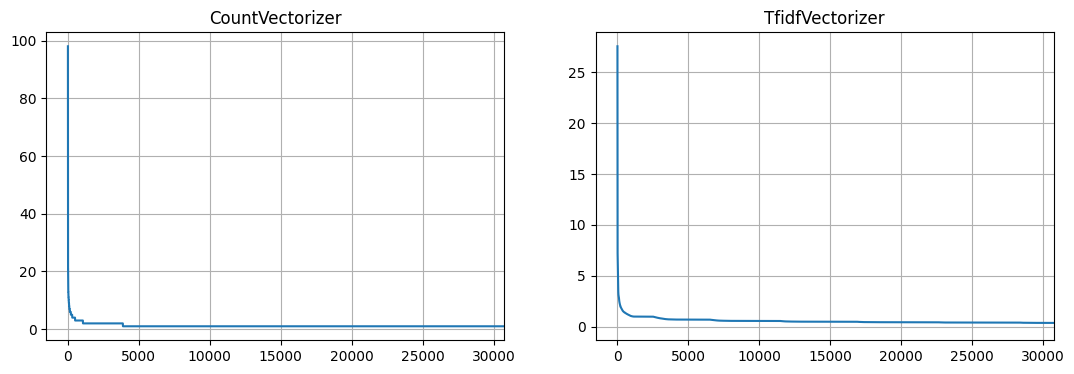

In [16]:
# Adding a column with preprocessed text
i = 0
dataset_versions = ['result']
brokers_names = BROKERS_OF_INTEREST

# Defining and filtering data to analyze
df = globals()[dataset_versions[i]].copy()
df = df[(df['publish_date'] >= '2022-10-01') &\
        (df['broker_name'].isin(brokers_names))]

# Forming aspects
df['aspects'] = df['text'].apply(lambda x: lemmatize_and_extract_pos(text=x, morph_parser=morph))

# Get counter and tfidf vectorizer statistics and results
min_n = 3
max_n = 3
vec_matrix, tfidf_matrix, cnt_vec, tfidf_vec = get_most_ranked_ngramms(df)

# Plot cropped results
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
x_length = len(cnt_vec)//3

axes[0].plot(range(len(cnt_vec)), cnt_vec['rank'])
axes[0].set_title('CountVectorizer')
axes[0].set_xlim([-0.05*x_length, x_length])
# axes[0].set_yscale('log')
axes[0].grid()

axes[1].plot(range(len(tfidf_vec)), tfidf_vec['rank'])
axes[1].set_title('TfidfVectorizer')
axes[1].set_xlim([-0.05*x_length, x_length])
# axes[1].set_yscale('log')
axes[1].grid()
plt.show()



* По графикам примерно видно, где заканчиваются потенциально полезные словосочетиния
* Выведем часть из них

In [17]:
# displaying the top
# display(cnt_vec.head(50))
display(tfidf_vec.head(50))

,term,rank
48939,открыть брокерский счёт,27.540314
80175,статус квалифицировать инвестор,22.366938
48810,открытие брокерский счёт,15.623913
88256,хотеть выразить благодарность,15.593689
47763,ответить всё вопрос,12.103920
88422,хотеть поблагодарить сотрудник,10.393550
57661,получение статус квалифицировать,9.489297
5459,брокерский счёт иис,8.807423
68292,работа служба поддержка,7.836367
65262,проблема не решить,7.679214


* По выведенной таблице можно предположить, что **чаще всего клиенты пишут отзывы касательно открытия брокерского счета, с целью поблагодарить сотрудников, по поводу получения статуса квалифицированного инвестора, о работе службы поддержки** и тд  


* Видно и то, что есть достаточно много "мусорной" информации, ее можно игнорировать или добавить новые слова к списку стоп-слов и пересчитать значения
* Поскольку слова лемматизированы, мы не можем всегда с уверенностью сказать, о чем идет речь или в каком контексте, так что этот инструмент можно использовать для подствечивания потенциально важной информации
* Стоит посмотреть детальнее, в каких предложениях встречаются эти н-граммы, чтобы делать дальнейшие выводы

In [18]:
i = 48939
# Get n-gramm of interest
ngramm = vec_matrix[:, i]
print(cnt_vec.loc[i, 'term'])

# Filter initial table by n-gramm
df_to_output = df[np.squeeze(ngramm.toarray()) > 0][['text', 'prediction', 'aspects', 'hash']]
print(f'{df_to_output.shape[0]} строка', end='\n\n')

# Output important data
print(['text', 'prediction'], end='\n\n')
# Counter
j = 0
for i, row in df_to_output[['text', 'prediction']].iterrows():
  print(j, row.tolist(), end='\n\n')
  j += 1


открыть брокерский счёт
98 строка

['text', 'prediction']

0 ['Открыл брокерский счет', 1]

1 ['Пригласила друга открыть брокерский счет по акции , но ранее у него был открыт ИИС', 1]

2 ['А тут пригласили меня друзья открыть брокерский счет в Тинькофф Брокере или Тинькофф Инвестициях (это одно и то же)', 1]

3 ['У моего друга был премиум, она создала ссылку, я перешла и открыла брокерский счет', 1]

4 ['Цитата: "19.09 я открыла брокерский счет и в соответствии с п', 1]

5 ['Давно являюсь клиентом  Тинькофф, в этом году по предложению менеджера открыла брокерский счёт, и регулярно получаю качественное обслуживание и рекомендации по инвестированию от персонального менеджера К-ва ВалерияВоспитанный и любезный менеджер, с отличным чувством юмора,  всегда доступно и понятно объясняет нюансы вылетов и падений тех или иных предметов вложения', 5]

6 ['Очень любезная девушка, рассказала и помогала открыть брокерский счет, а так же проконсультировала по моей просьбе как обменять валюту по боле

* Обернем данный пайплайн в функцию и проанализируем отдельно положительные и негативные предложения из отзывов по БКС

In [19]:
def review_analization_pipeline(df: pd.DataFrame,
                                min_n:int = 3,
                                max_n:int = 3) -> Iterable[Union[pd.DataFrame,
                                                            pd.DataFrame,
                                                            pd.DataFrame,
                                                            pd.DataFrame]]:
    '''
    Func for analyzing reviews pipeline
    '''
    # Forming aspects
    df['aspects'] = df['text'].apply(lambda x: lemmatize_and_extract_pos(text=x, morph_parser=morph))

    # Get counter and tfidf vectorizer statistics and results

    vec_matrix, tfidf_matrix, cnt_vec, tfidf_vec = get_most_ranked_ngramms(df,
                                                                           min_n=min_n,
                                                                           max_n=max_n)

    # Plot cropped results
    fig, axes = plt.subplots(1, 2, figsize=(13, 4))
    x_length = len(cnt_vec)//3

    axes[0].plot(range(len(cnt_vec)), cnt_vec['rank'])
    axes[0].set_title('CountVectorizer')
    axes[0].set_xlim([-0.05*x_length, x_length])
    # axes[0].set_yscale('log')
    axes[0].grid()

    axes[1].plot(range(len(tfidf_vec)), tfidf_vec['rank'])
    axes[1].set_title('TfidfVectorizer')
    axes[1].set_xlim([-0.05*x_length, x_length])
    # axes[1].set_yscale('log')
    axes[1].grid()
    plt.show()

    return df, vec_matrix, tfidf_matrix, cnt_vec, tfidf_vec


def display_important_data(initial_table: pd.DataFrame,
                           dictionary_matrix: np.array,
                           sorted_table: pd.DataFrame,
                           indx: int) -> list:
    '''
    Func for displaying important data out of reviews
    '''

    # Get n-gramm of interest
    ngramm = dictionary_matrix[:, indx]
    print(sorted_table.loc[indx, 'term'])

    # Filter initial table by n-gramm
    df_to_output = initial_table[np.squeeze(ngramm.toarray()) > 0][['text', 'prediction', 'aspects', 'hash']]
    print(f'{df_to_output.shape[0]} rows', end='\n\n')

    # Output important data
    print(['text', 'prediction', 'hash'], end='\n\n')
    # Counter
    j = 0
    for i, row in df_to_output[['text', 'prediction', 'hash']].iterrows():
      print(j, row.tolist(), end='\n\n')
      j += 1

    return df_to_output['hash'].tolist()


### Проанализируем негативные предложения из отзывов о БКС за последние два года

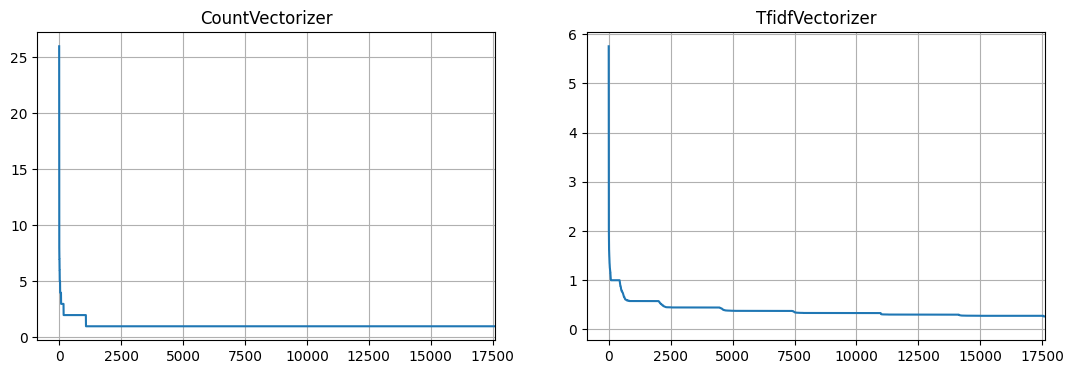

,term,rank
28400,открыть брокерский счёт,26
28309,открытие брокерский счёт,10
30493,перевод ценный бумага,9
9700,доступ личный кабинет,9
21512,не мочь решить,8
18115,месяц не мочь,8
26295,обычный брокерский счёт,7
961,акция пик акция,7
20668,не возвращать деньга,7
32638,позвонить горячий линия,7


In [20]:
# Adding a column with preprocessed text
i = 0
dataset_versions = ['result']
brokers_names = BKS

# Defining and filtering data to analyze
df = globals()[dataset_versions[i]].copy()
df = df[(df['publish_date'] >= '2021-10-01') &\
        (df['broker_name'].isin(brokers_names)) &\
        (df['prediction'] <= 3)]


neg_df, neg_vec_matrix, neg_tfidf_matrix, neg_cnt_vec, neg_tfidf_vec = review_analization_pipeline(
                                                                        df,
                                                                        min_n=3,
                                                                        max_n=4)

# displaying the top
display(neg_cnt_vec.head(50))
# display(tfidf_vec.head(50))

#### Примеры

In [21]:
indx = 20668

hash_list = display_important_data(initial_table=neg_df,
                                    dictionary_matrix=neg_tfidf_matrix,
                                    sorted_table=neg_tfidf_vec,
                                    indx=indx)

не возвращать деньга
7 rows

['text', 'prediction', 'hash']

0 ['БКС не возвращает деньги с ИИС', 1, 16432295931799093051]

1 ['Брокер не возвращает деньги, обращаюсь в суд', 1, 18131487664935486789]

2 ['БКС не возвращает деньги', 1, 4475343431275251642]

3 ['Уже месяц не возвращают деньги', 1, 11109723196286858915]

4 ['Не возвращают деньги', 1, 7304968900911723223]

5 ['БКС не возвращает деньги', 1, 13172151878115969804]

6 ['БКС не возвращает деньги', 1, 12898619767050010283]



* Тут по какой-то причине не возвращают деньги клиентам
* Можно детальнее рассмотреть отзывы полностью по Хэшам этих самых отзывов

In [22]:
print(*review_data[review_data['hash'].isin(hash_list)]['full_review'].tolist(), sep='\n\n', )

БКС не возвращает деньги с ИИС!. Уже больше месяца пытаюсь закрыть ИИС(более 3 лет) и вывести  деньги!16 февраля 2023 г. пришел в офис БКС с просьбой закрыть ИИС и перевести деньги мне на счет,  подписал все необходимые документы. Сказали что такая операция займет 15 дней. По истечении 15 дней счет не был закрыт и деньги  не переведены, и 6 марта я написал в поддержку с просьбой разобраться с данной ситуацией. 9 марта мне на почту пришло сообщение о том что они не могут закрыть счет и в этом письме указан обычный брокерский счет (не ИИС). Профессионалы рынка перепутали счет и стали закрывать другой. Написал об этом в поддержку, они очень сильно извинялись и сказали что решат проблему в ближайшее время. Проблема до сих пор не решена! Такое ощущение что БКС даже и не занимается этим вопросом

Брокер не возвращает деньги, обращаюсь в суд. Хотел бы предостеречь от работы с этим брокером, рискуете потерять деньги.  27.09.22 отправил деньги на пополнение счета, но средства не зачлись, т.к. б

* В итоге видно, что клиенты столкнулись с проблемой незачисленя денег на ИИС при его пополнении

In [23]:
indx = 46002

hash_list = display_important_data(initial_table=neg_df,
                       dictionary_matrix=neg_tfidf_matrix,
                       sorted_table=neg_tfidf_vec,
                       indx=indx)

статус квалифицировать инвестор
7 rows

['text', 'prediction', 'hash']

0 ['Не присваивает статус "квалифицированного инвестора" по своему надуманному регламенту, противоречащему общим правилам', 1, 12811982096979207932]

1 ['Уже в который раз не могу получить статус "квалифицированного инвестора" у брокера БКС, который отказывает в присвоении якобы из-за того, что у меня деньги в том числе на эскроу счете', 1, 12811982096979207932]

2 ['Нет нигде в законе и правилах запрета на использование денег с эскроу счета для их учета при получении статуса квалифицированного инвестора', 1, 12811982096979207932]

3 ['Еще хочу сказать спасибо финансовому советнику, которая полностью проконсультировала меня по телефону( потому что я уехал из города) по вопросу получения статуса квалифицированным инвестора', 1, 5797049937152253030]

4 ['Хотел получить статус квалифицированного инвестора, но не попадал ни под один критерий', 1, 4639180108876093233]

5 ['Недавно решил, что пора озадачиться получением 

* Тут по какой-то причине людям не дают статус квалифицированного инвестора, детальнее о причинах можно будет так же узнать из полного текста по хэшам

### Проанализируем положительные предложения из отзывов о БКС

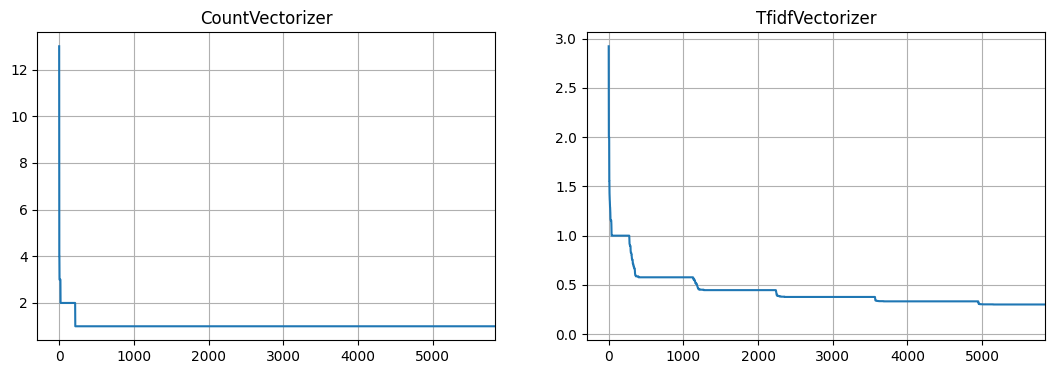

,term,rank
8817,открыть брокерский счёт,13
16721,хотеть выразить благодарность,4
2760,горячий линия чат,4
16773,хотеть поделиться свой,4
16774,хотеть поделиться свой опыт,3
833,брокер решить попробовать,3
13441,решить открыть счёт,3
13958,свой финансовый советник,3
6637,написать чат поддержка,3
16764,хотеть поблагодарить сотрудник,3


In [24]:
# Adding a column with preprocessed text
i = 0
dataset_versions = ['result']
brokers_names = BKS

# Defining and filtering data to analyze
df = globals()[dataset_versions[i]].copy()
df = df[(df['publish_date'] >= '2020-10-01') &\
        (df['broker_name'].isin(brokers_names)) &\
        (df['prediction'] > 3)]


pos_df, pos_vec_matrix, pos_tfidf_matrix, pos_cnt_vec, pos_tfidf_vec = review_analization_pipeline(
                                                                df,
                                                                min_n=3,
                                                                max_n=4)

# displaying the top
display(pos_cnt_vec.head(20))
# display(tfidf_vec.head(20))

In [25]:
indx = 16721

hash_list = display_important_data(initial_table=pos_df,
                                  dictionary_matrix=pos_tfidf_matrix,
                                  sorted_table=pos_tfidf_vec,
                                  indx=indx)

хотеть выразить благодарность
4 rows

['text', 'prediction', 'hash']

0 ['Хочу выразить благодарность эксперту БКС Г-ву Игорю за его профессиональные и профитные инвестидеи', 5, 3782951523008627261]

1 ['Хочу выразить благодарность сотрудникам офиса на пр-те Мира', 5, 13192698186903730473]

2 ['Хочу выразить благодарность консультантам БКС', 5, 6260879513481652304]

3 ['От всей души хочу выразить благодарность моему менеджеру Татьяне К-ой, с которой мы работаем уже на протяжении 1', 5, 9950056677053828514]



* Детальнее о положительных кейсах также можем посмотреть из самого отзыва по хэшу

In [26]:
print(*review_data[review_data['hash'].isin(hash_list)]['full_review'].tolist(), sep='\n\n', )

Благодарность за профессионализм. Хочу выразить благодарность эксперту БКС Г-ву Игорю за его профессиональные и профитные инвестидеи. Я сам далек от экономики, но вкладывать в свое будущее и будущее детей хотелось, поэтому открыл брокерский счет. Решил, что буду опираться на мнения экспертов при выборе активов. В прошлом году летом в первый раз решил вложить крупную сумму денег. Тогда как раз появилась рекомендация Игоря Г-ва по инвестированию в Сбербанк. Честно говоря, у меня были сомнения в начале, потому что банковский сектор на тот момент переживал не лучшие времена, поверить в рост акций было сложно. Но я посмотрел по статистике, у Игоря большая часть инвестидей закрывается в профит. Решил рискнуть. В феврале этого года я продал акции Сбербанка и получил обещанную прибыль в 33%. Даже я, далекий от инвестиций, понимаю, что это очень хороший результат.

Перенос активов от другого брокера. Хочу выразить благодарность сотрудникам офиса на пр-те Мира. Обратилась к ним с вопросом по пер

## Итог:
* Написан парсер для отзывов брокеров с сайта Banki.ru
* Собраны все данные по отзывам о всех доступных брокерах
* Данные были обработаны и проанализированны в разрезах сопутствующих признаков (графики + выводы)
* Выбрана предобученная модель для анализа танальности текстов (nlptown/bert-base-multilingual-uncased-sentiment)
* Пердобработаны данные для подачи на вход модели
* Выполена классификация предложений в отзывах
* При помощи классических подходов nlp (CountVectorizer и TF-IDF) выполнен анализ текстов

Данный блок добавил как потенциальную возможность для улучшения качества работы модели

## Finefuning model


* Нашел датасет, который потенициально мог бы помочь для дообучения предобученных моделей на русских текстах отзывов, но поскольку области сервисов, по которым датасет собран, сильно отличается от текущей области, распределения признаков могут быть сильно смещены
* Также пока что можно дообучить модель на имеющихся данных

In [ ]:
!git clone https://github.com/yandex/geo-reviews-dataset-2023.git

Cloning into 'geo-reviews-dataset-2023'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Receiving objects: 100% (10/10), 167.74 KiB | 41.93 MiB/s, done.


Данные надо будет предобрабатывать и оценивать качество

In [ ]:
experim_dataset = pd.read_table('/content/geo-reviews-dataset-2023/geo-reviews-dataset-2023.tskv')
experim_dataset

,"address=Екатеринбург, ул. Московская / ул. Волгоградская / ул. Печатников",name_ru=Московский квартал,rating=3.,rubrics=Жилой комплекс,"text=Московский квартал 2.\nШумно : летом по ночам дикие гонки. Грязно : кругом стройки, невозможно открыть окна (16 этаж! ), вечно по району летает мусор. Детские площадки убогие, на большой площади однотипные конструкции. Очень дорогая коммуналка. Часто срабатывает пожарная сигнализация. Жильцы уже не реагируют. В это время, обычно около часа, не работают лифты. Из плюсов - отличная планировка квартир ( Московская 194 ), на мой взгляд. Ремонт от застройщика на 3-. Окна вообще жуть - вместо вентиляции. По соотношению цена/качество - 3."
0,"address=Московская область, Электросталь, прос...",name_ru=Продукты Ермолино,rating=5.,rubrics=Магазин продуктов;Продукты глубокой за...,"text=Замечательная сеть магазинов в общем, хор..."
1,"address=Краснодар, Прикубанский внутригородско...",name_ru=LimeFit,rating=1.,rubrics=Фитнес-клуб,"text=Не знаю смутят ли кого-то данные правила,..."
2,"address=Санкт-Петербург, проспект Энгельса, 11...",name_ru=Snow-Express,rating=4.,rubrics=Пункт проката;Прокат велосипедов;Сапсё...,text=Хорошие условия аренды. \nДружелюбный пер...
3,"address=Тверь, Волоколамский проспект, 39",name_ru=Студия Beauty Brow,rating=5.,"rubrics=Салон красоты;Визажисты, стилисты;Сало...",text=Топ мастер Ангелина топ во всех смыслах )...
4,"address=Иркутская область, Черемхово, Первомай...",name_ru=Tele2,rating=5.,rubrics=Оператор сотовой связи;Интернет-провайдер,"text=Приятное общение, все доступно объяснили,..."
...,...,...,...,...,...
499994,"address=Москва, Южный административный округ, ...",name_ru=Бирюлёво-Пассажирская,rating=4.,rubrics=Железнодорожная станция,"text=Охрана кривая но добрая, двери не закрыва..."
499995,"address=Москва, Южный административный округ, ...",name_ru=Бирюлёво-Пассажирская,rating=4.,rubrics=Железнодорожная станция,text=По сравнению со многими современными плат...
499996,"address=Новосибирск, Коммунистическая улица, 48А",rating=5.,"rubrics=Бар, паб","text=Приятная атмосфера, прекрасное вино, волш...",NaN
499997,"address=Астраханская область, Харабалинский район",name_ru=Сарай-Бату,rating=5.,rubrics=Достопримечательность,text=Был с семьёй 13.06.23 Отличное место. Рек...


In [27]:
# Available variable names with datasets
dataset_versions = ['review_data', 'exploded_data']
i = 0

finetune_data = globals()[dataset_versions[i]][['full_review', 'rating_val', 'hash']]

finetune_data.columns = ['text', 'labels', 'hash']
finetune_data['labels'] = finetune_data['labels'] - 1
train_data, test_data = train_test_split(finetune_data, test_size=0.05, random_state=42)
train_data

<ipython-input-27-4cb921005c15>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  finetune_data['labels'] = finetune_data['labels'] - 1


,text,labels,hash
2792,Не выплатили вознаграждение за друзей. Участво...,0,16375227736754548476
1610,Проблема с возвратом комиссии. Добрый день. Се...,0,15930834960369553624
1957,Опыт работы с Финам. Я рад поделиться положите...,4,7430169146074395396
315,Инвестиции. 15.08.2023.У меня сгорел подарок в...,4,6132507016404950036
3771,Некомпетентность и волокита. В связи с санкция...,0,871591853429194951
...,...,...,...
1130,Вернули деньги за мою ошибку. 29.12.2022 подкл...,4,9367877361303863165
1294,Нет вывода средств на счет стороннего банка. -...,1,8336547484029583626
860,Тинькофф Банк. Хочу поблагодарить сотрудника Т...,4,7106419321219718129
3507,Проблема с заказом документа. Добрый день!31.1...,0,8588876748426867162


In [28]:
# Fromin datasetdict object for our train and test data
classif_dataset = DatasetDict({
    'train': Dataset.from_pandas(train_data.reset_index(drop=True)),
    'test': Dataset.from_pandas(test_data.reset_index(drop=True))
    })
classif_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'hash'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels', 'hash'],
        num_rows: 195
    })
})

In [29]:
# Tokenizing data to feed models
tokenize = lambda dataset: tokenizer(dataset['text'], truncation=True, return_tensors='pt', padding=True)
classif_dataset_tokenized = classif_dataset.map(tokenize, batched=True)
classif_dataset_tokenized

Map:   0%|          | 0/3705 [00:00<?, ? examples/s]

Map:   0%|          | 0/195 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'hash', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3705
    })
    test: Dataset({
        features: ['text', 'labels', 'hash', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 195
    })
})

In [30]:
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    '''
    Func to compute accuracy for finetuning
    '''
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [31]:
# Load necessary tokenizer and model
model_checkpoint = 'nlptown/bert-base-multilingual-uncased-sentiment'
# model_checkpoint = 'marianna13/bert-multilingual-sentiment'

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=5)

# Setting training arguments
args = TrainingArguments(
    "clf",
    evaluation_strategy = "steps",
    eval_steps=200,
    learning_rate=3e-5,
    per_device_train_batch_size=7,
    per_device_eval_batch_size=7,
    num_train_epochs=4,
    weight_decay=0.001,
)


In [32]:
# Creating trainer object
trainer = Trainer(
    model,
    args,
    train_dataset=classif_dataset_tokenized["train"],
    eval_dataset=classif_dataset_tokenized["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Finetuning model
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
200,No log,0.677349,0.861538
400,No log,0.565439,0.861538
600,0.330200,0.532611,0.861538
800,0.330200,0.768884,0.866667
1000,0.274200,0.651289,0.866667
1200,0.274200,0.731131,0.871795
1400,0.274200,0.679867,0.871795
1600,0.194700,0.791556,0.841026
1800,0.194700,0.801335,0.866667
2000,0.119200,0.811153,0.861538


TrainOutput(global_step=2120, training_loss=0.22279894936759517, metrics={'train_runtime': 1670.8988, 'train_samples_per_second': 8.869, 'train_steps_per_second': 1.269, 'total_flos': 3899410871316480.0, 'train_loss': 0.22279894936759517, 'epoch': 4.0})

In [ ]:
# Saving finetuned model
trainer.save_model('finetuned_model')